# <span style="color:purple">Test: </span>

# Visualizing ArcPy Outputs Using .lyr Files

### >>>> DRAFT <<<<

Date: 10-15-2018

Summary: This notebook contains tests and attempted workarounds to leverage .lyr files when working from a jupyter notebook

# Setup

Import packages (The arcgis.features import is recommended from the API documentation for working with Spatially-enabled Dataframes)

In [1]:
import arcpy
import arcgis
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import os

Set reference to sample data

In [2]:
# Path to File Geodatabase containing available data
file_geodatabase = "data//retail.gdb"

# Path to retail business data
businesses_fc = file_geodatabase + "//us_businesses_pittsburgh"
restaurants_fc = file_geodatabase + "//restaurants_pittsburgh"

Connect to a Web GIS

In [3]:
# Connect to ArcGIS Online
gis = arcgis.gis.GIS("https://esrifederal.maps.arcgis.com", username="Anieto_esrifederal")

Enter password: ········


# Using Symbology Layers (.lyr files) with Data on a Hosted Notebook

So far, the only known way to interact with symbology layer files and data produced on a notebook is by leveraging an ArcGIS Pro (or ArcMap) installation on the system executing the notebook cells and publishing from ArcPy to a WebGIS that can then use the symbolized outputs. 

This is a painful workaround, and there may be other ways to work around this (but none that I've found yet). 

The way this process works is as follows:

1. Run the needed tool in the notebook cell.
2. Use an ArcGIS Pro Project or ArcMap MXD to load the output data from the notebook cell. 
3. Apply the .lyr file using ArcPy.
4. Publish the layer as a service to a Web GIS.
5. Retrieve the published item in the notebook.

The following is such an example:

## 1. Run the needed tool in the notebook cell.

In [20]:
hotspots_result_object = arcpy.stats.OptimizedHotSpotAnalysis(restaurants_fc, 
                                                              "{0}//{1}_HotSpots".format(file_geodatabase, "Restaurants"),  
                                                              "SALESVOL")

In [21]:
for i in range(0, hotspots_result_object.messageCount):
    print(hotspots_result_object.getMessage(i))

Start Time: Monday, October 15, 2018 8:07:08 PM
Running script OptimizedHotSpotAnalysis...

************************** Initial Data Assessment ***************************
Making sure there are enough weighted features for analysis....
    - There are 5026 valid input features.

Evaluating the Analysis Field values....
    - SALESVOL Properties:
        Min:           0.0000
        Max:       14035.0000
        Mean:        802.6454
        Std. Dev.:  1130.5548
Looking for locational outliers....
    - There were 88 outlier locations; these will not be used to compute the optimal fixed distance band.

***************************** Scale of Analysis ******************************
Looking for an optimal scale of analysis by assessing the intensity of clustering at increasing distances....
    - The optimal fixed distance band is based on peak clustering found at 5844.2536 Meters

***************************** Hot Spot Analysis ******************************
Finding statistically signifi

In [22]:
hotspots_result_object.getOutput(0)

'data\\\\retail.gdb\\Restaurants_HotSpots'

## 2. Use an ArcGIS Pro Project or ArcMap MXD to load the output data from the notebook cell. 

We need to use an ArcGIS Pro project (or ArcMap MXD). Let's set the path to a project here.

In [23]:
pro_project_path = r"data/pro_project_template/ProProjectTemplate/ProProjectTemplate.aprx"

This symbology layer was previously saved using ArcGIS Pro...

![layer](img/save_lyr.png "save layer")

In [24]:
lyrfile = arcpy.mp.LayerFile(r"symbology/optimizedhotspots_point_symbology.lyrx")
hotspots_symbology_lyr = lyrfile.listLayers()[0]
hotspots_symbology_lyr

Next, we need to use ArcPy's project > map > layer structure to set variables and add our optimized hot spots output as a layer

In [25]:
aprx  = arcpy.mp.ArcGISProject(pro_project_path)
map_obj = aprx.listMaps()[0]

In [26]:
for layer in map_obj.listLayers():
    print(layer.name)

World Topographic Map
World Hillshade


Let's add the layer to the map

In [27]:
map_obj.addLayer(hotspots_symbology_lyr)

In [28]:
for layer in map_obj.listLayers():
    print(layer.name)

OHS_restaurants
World Topographic Map
World Hillshade


In [29]:
hotspots_map_layer = map_obj.listLayers("OHS_restaurants")[0]
hotspots_map_layer

In [30]:
connprop = hotspots_map_layer.connectionProperties

In [34]:
new_conn_properties = {'connection_info': {'database': file_geodatabase},
                       'dataset': 'Restaurants_HotSpots',
                       'workspace_factory': 'File Geodatabase'}

In [35]:
hotspots_map_layer.updateConnectionProperties(hotspots_map_layer.connectionProperties, new_conn_properties)

In [36]:
hotspots_map_layer.connectionProperties

{'connection_info': {'database': 'data//retail.gdb'},
 'dataset': 'Restaurants_HotSpots',
 'workspace_factory': 'File Geodatabase'}

## 3. Publish the layer as a service to a Web GIS.

Create a feature sharing draft object

References:
- http://pro.arcgis.com/en/pro-app/arcpy/sharing/featuresharingdraft-class.htm)
- http://pro.arcgis.com/en/pro-app/tool-reference/server/stage-service.htm

In [37]:
import os

# Set output file names
outdir = r"data\publishing"
service = "OHS_restaurants"
sddraft_filename = service + ".sddraft"
sddraft_output_filename = os.path.join(outdir, sddraft_filename)

Create SharingDraft and set service properties

In [38]:
# Create SharingDraft and set service properties
feature_sharingdraft_obj = map_obj.getWebLayerSharingDraft(server_type='MY_HOSTED_SERVICES', 
                                                           service_type='FEATURE', 
                                                           service_name=service)

feature_sharingdraft_obj.description = "Optimized Hot Spots results for restaurants in Pittsburgh, PA"
feature_sharingdraft_obj.tags = "Optimized Hot Spots"
feature_sharingdraft_obj.summary = "My Summary"

Create Service Definition Draft File

In [39]:
feature_sharingdraft_obj.exportToSDDraft(sddraft_output_filename)

Stage Service

In [ ]:
sd_filename = service + ".sd"
sd_output_filename = os.path.join(outdir, sd_filename)
arcpy.StageService_server(sddraft_output_filename, sd_output_filename)

In [ ]:
# Share to portal
print("Uploading Service Definition...")
arcpy.UploadServiceDefinition_server(sd_output_filename, "My Hosted Services")

## 4. Retrieve the published item in the notebook.

In [48]:
hotspots_map = gis.map("Pittsburgh")
hotspots_map

MapView(layout=Layout(height='400px', width='100%'))

<Item title:"OHS_restaurants" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
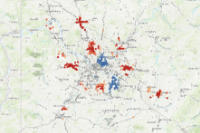

In [49]:
hotspots_published_item = gis.content.search("OHS_restaurants", item_type="Feature Service")[1]
hotspots_published_item

In [50]:
hotspots_map.add_layer(hotspots_published_item)

## Appendix: Renderer Testing (In Progress)

In [53]:
renderer = hotspots_map_layer.symbology.renderer

In [54]:
renderer

<graduated_colors_renderer object>

In [55]:
hot_spots_map = gis.map("Pittsburgh")
hot_spots_map

MapView(layout=Layout(height='400px', width='100%'))

<Item title:"OHS_restaurants_notsymbolized" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
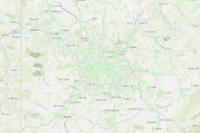

In [58]:
hot_spots_item = gis.content.search("OHS_restaurants_notsymbolized", item_type="Feature Service")[0]
hot_spots_item

In [59]:
hot_spots_map.add_layer(hot_spots_item)